In [12]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import time

import fannypack
from lib import dpf, panda_models, panda_datasets, panda_training

print(torch.__version__, np.__version__)

1.3.0 1.17.3


In [14]:
# Experiment configuration
experiment_name = "dpf_feb16_dynamics_5"
dataset_args = {
    'use_proprioception': True,
    'use_haptics': True,
    'use_vision': True,
    'vision_interval': 2,
}

In [15]:
# Create models & training buddy

dynamics_model = panda_models.PandaDynamicsModel()
measurement_model = panda_models.PandaSimpleMeasurementModel()

pf_model = panda_models.PandaParticleFilterNetwork(
    dynamics_model,
    measurement_model
)

buddy = fannypack.utils.Buddy(
    experiment_name,
    pf_model,
    optimizer_names=["e2e", "dynamics", "measurement"]
)

[buddy-dpf_feb16_dynamics_5] Using device: cpu
[buddy-dpf_feb16_dynamics_5] No checkpoint found


# Dynamics Model Pre-Training

In [16]:
dynamics_trainset = panda_datasets.PandaSubsequenceDataset(
    "data/gentle_push_10.hdf5",
    subsequence_length=16,
    **dataset_args
)

In [25]:
dataloader = torch.utils.data.DataLoader(dynamics_trainset, batch_size=16, shuffle=True, num_workers=2)
pf_model.dynamics_model.state_noise_stddev = (.1, .1)
    
for i in range(10000):
    print("Training epoch", i)
    panda_training.train_dynamics_recurrent(buddy, pf_model, dataloader, log_interval=1)
    print()


Training epoch 0



Epoch loss: 0.10228515

Training epoch 1



Epoch loss: 0.054758076

Training epoch 2



Epoch loss: 0.17071876

Training epoch 3



Epoch loss: 0.065364696

Training epoch 4



Epoch loss: 0.05736615

Training epoch 5



Epoch loss: 0.07229853

Training epoch 6



Epoch loss: 0.07439334

Training epoch 7



Epoch loss: 0.07584832

Training epoch 8



Epoch loss: 0.081449054

Training epoch 9



Epoch loss: 0.04121737

Training epoch 10



Epoch loss: 0.12695162

Training epoch 11



Epoch loss: 0.06792606

Training epoch 12



Epoch loss: 0.058153793

Training epoch 13



Epoch loss: 0.090315945

Training epoch 14



Epoch loss: 0.065186314

Training epoch 15



Epoch loss: 0.0664368

Training epoch 16



Epoch loss: 0.06480131

Training epoch 17



Epoch loss: 0.08302669

Training epoch 18



Epoch loss: 0.09214034

Training epoch 19



Epoch loss: 0.063672796

Training epoch 20



Epoch loss: 0.04935383

Training epoch 21



Epoch loss: 0.11418489

Training epoch 22



Epoch loss: 0.04633797

Training epoch 23



Epoch loss: 0.037967738

Training epoch 24



Epoch loss: 0.07703684

Training epoch 25



Epoch loss: 0.1068534

Training epoch 26



Epoch loss: 0.095435195

Training epoch 27



Epoch loss: 0.12947169

Training epoch 28



Epoch loss: 0.064264245

Training epoch 29



Epoch loss: 0.076580405

Training epoch 30



Epoch loss: 0.08498272

Training epoch 31



Epoch loss: 0.07447017

Training epoch 32



Epoch loss: 0.06772048

Training epoch 33



Epoch loss: 0.04358294

Training epoch 34



Epoch loss: 0.08285906

Training epoch 35



Epoch loss: 0.081461646

Training epoch 36


KeyboardInterrupt: 

# Measurement Model Pre-Training

In [ ]:

measurement_trainset = panda_datasets.PandaMeasurementDataset(
    "data/gentle_push_100.hdf5",
    samples_per_pair=10,
    **dataset_args
)

In [52]:
measurement_trainset_loader = torch.utils.data.DataLoader(
    measurement_trainset,
    batch_size=64,
    shuffle=True,
    num_workers=16)

for i in range(15):
    print("Training epoch", i)
    panda_training.train_measurement(buddy, pf_model, measurement_trainset_loader, log_interval=20)
    print()

# measurement_trainset_loader = torch.utils.data.DataLoader(measurement_trainset, batch_size=64, shuffle=True, num_workers=2)
# for i in range(1):
#     print("Training epoch", i)
#     panda_training.train_measurement(buddy, pf_model, measurement_trainset_loader, log_interval=100)
#     print()

# measurement_trainset_loader = torch.utils.data.DataLoader(measurement_trainset, batch_size=256, shuffle=True, num_workers=2)
# for i in range(1):
#     print("Training epoch", i)
#     panda_training.train_measurement(buddy, pf_model, measurement_trainset_loader, log_interval=100)
#     print()



Training epoch 0



Epoch loss: 3689.7896

Training epoch 1



Epoch loss: 2454.547

Training epoch 2



Epoch loss: 2195.786

Training epoch 3



Epoch loss: 2119.5444

Training epoch 4



Epoch loss: 2003.1733

Training epoch 5



Epoch loss: 1982.4457

Training epoch 6



Epoch loss: 1883.915

Training epoch 7



Epoch loss: 1867.9833

Training epoch 8



Epoch loss: 1815.0703

Training epoch 9



Epoch loss: 1708.1825

Training epoch 10



Epoch loss: 1796.486

Training epoch 11



Epoch loss: 1702.8817

Training epoch 12



Epoch loss: 1663.9946

Training epoch 13



Epoch loss: 1448.7733

Training epoch 14



Epoch loss: 1440.8864



In [ ]:
buddy.save_checkpoint(label="before_e2e_training")

# End-to-end Training

In [44]:
# Create end-to-end dataset

e2e_trainset = panda_datasets.PandaParticleFilterDataset(
    "data/gentle_push_100.hdf5",
    subsequence_length=16,
    particle_count=30,
    particle_stddev=(.1, .1),
    **dataset_args
)

Parsed data: 1307 active, 193 inactive
Keeping (inactive): 193


In [45]:
print(len(e2e_trainset.subsequences))

1500


In [18]:
##### Train end-to-end
pf_model.dynamics_model.state_noise_stddev = (0.05, 0.05)

pf_model.freeze_measurement_model = False
pf_model.freeze_dynamics_model = True

# e2e_trainset_loader = torch.utils.data.DataLoader(e2e_trainset, batch_size=32, shuffle=True, num_workers=2)
# for i in range(3):
#     print("Training epoch", i)
#     panda_training.train_e2e(buddy, pf_model, e2e_trainset_loader, loss_type="mse", log_interval=100)

e2e_trainset_loader = torch.utils.data.DataLoader(e2e_trainset, batch_size=32, shuffle=True, num_workers=2)
for i in range(20):
    print("Training epoch", i)
    panda_training.train_e2e(buddy, pf_model, e2e_trainset_loader, loss_type="mse")

NameError: name 'e2e_trainset' is not defined

In [ ]:
buddy.save_checkpoint()

# Model eval

In [8]:
eval_trajectories = panda_datasets.load_trajectories(
    "data/gentle_push_10.hdf5",
    **dataset_args
)

### Final Model

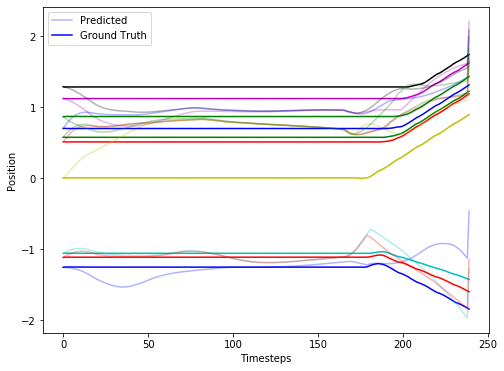

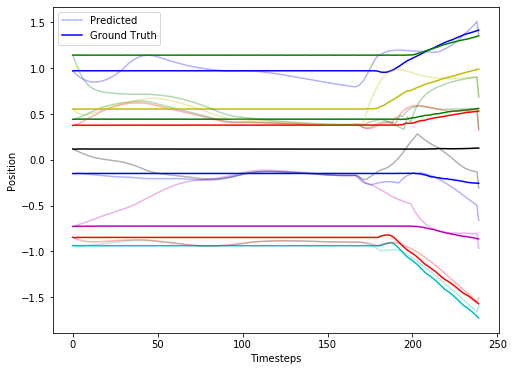

X RMSE:  0.2848474673991021
Y RMSE:  0.2539596673912457
(0.0, 0.0)


In [27]:
pf_model.dynamics_model.state_noise_stddev = (0., 0.)
# pf_model.dynamics_model.state_noise_stddev = (1., 1.)
pred, actual = panda_training.rollout(pf_model, eval_trajectories, start_time=0, max_timesteps=1000, particle_count=200, noisy_dynamics=True)
panda_training.eval_rollout(pred, actual, plot=True)
print(pf_model.dynamics_model.state_noise_stddev)

### Model without end-to-end training

In [ ]:
pf_model.dynamics_model.state_noise = (0.005, 0.005)


# Back up model
buddy.save_checkpoint()

# Load the pre-end-to-end-training version of the model & evaluate
buddy.load_checkpoint(label="before_e2e_training")

pred, actual = panda_training.rollout(pf_model, eval_trajectories, start_time=0, max_timesteps=1000, particle_count=200, noisy_dynamics=True)
panda_training.eval_rollout(pred, actual, plot=True)

# Restore model
buddy.load_checkpoint()